# Data Viz in Julia: Makie

I've tried `Gadfly` and enjoyed the grammar of graphics style of plotting, but I've heard lots of love for `Makie` as another library worth checking out. I'll use the `CairoMakie` backend for now, but it looks like the really fun stuff comes with the other backends like GLMakie in terms of interactivity and even making little interact apps.

## Motivation

* See the [`BeautifulMakie` site](https://lazarusa.github.io/BeautifulMakie/) for some great examples
* You can do Latex in your plots with the `LaTeXStrings` package

# Makie

## First impressions

* The key concepts to think about are:
    * Layouts and Figures
    * Layoutables
    * Plotting Functions
* The [Figure](https://makie.juliaplots.org/stable/documentation/figure/index.html#figures) object: Plots are created by initializing a Figure object (either explicitly or implicitly with a plotting function call like `lines`)
    * Example: `f = Figure(resolution = (600, 400))`
    * Like the size of the canvas, and you can specify how `Layoutables` like axes will go    
* Layouts
    * Makie supports some complex layouts - with your Figure object you can add subplots by adding axes
* [`Layoutables`](https://makie.juliaplots.org/stable/documentation/layoutables/)
    * Axes and Legends are examples of `Layoutables` - what they call stuff that you can add to the Layout. 
* [Plotting Functions](https://makie.juliaplots.org/stable/examples/layoutables/)
    * i.e. `lines`, `scatter`, `series`, etc. 
    * Calling a plotting function without referencing a figure will implicitly create a Figure
    * What makes `Makie` so verbose is the fact that there are so many possible attributes that you can modify and set to customize the heck out of your chart. 
    * See [plotting functions](https://makie.juliaplots.org/stable/examples/plotting_functions/) documentation for full list of attributes
* Observables
    * Special workflow for interactive visualizations
    * An `Observable` is an object that a `Listener` (usually a function) will react to whenever the `Observable` changes

Overall, the workflow feels like `matplotlib` or base `plotly` in that you're creating a canvas with your `Figure` and then adding components with `Plotting Functions` or stuff like `Axes` and `Legend`s to that `Figure` incrementally. Each component has a bunch of attributes that you can fiddle around with and tweak to get the customized visualization that you want. 

In [6]:
using CairoMakie, ColorSchemes
using DataFramesMeta
using AlgebraOfGraphics, PalmerPenguins

ENV["COLUMNS"] = 1000;

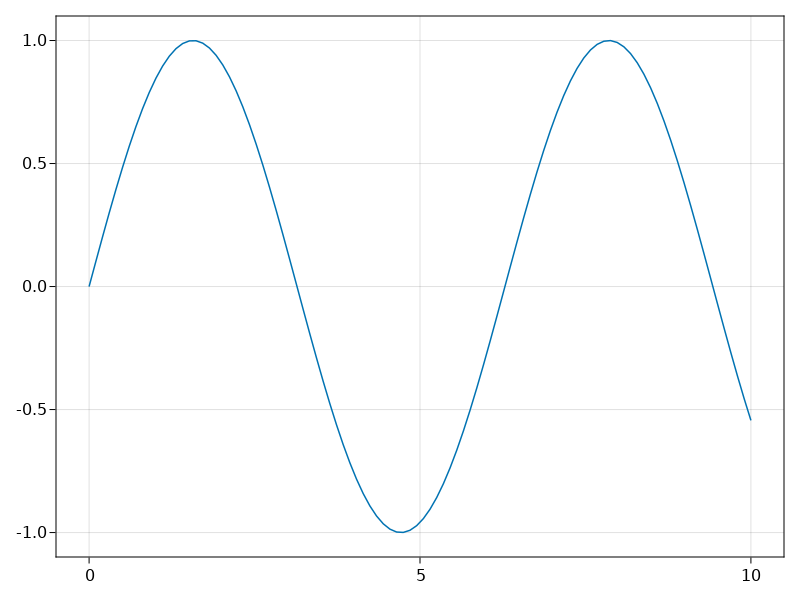

In [80]:
x = range(0, 10, length=100)
y = sin.(x)
lines(x, y)

The `lines` call can be unpacked into a `figure`, `axis`, and `plotobject` separately (aka a `FigureAxisPlot`). Use `attributes` to see what kinds of atributes you can set on any of these:

In [83]:
f, ax, pltobject = lines(x, y)
pltobject.attributes

Attributes with 18 entries:
  color => RGBA{Float32}(0.0,0.447059,0.698039,1.0)
  colormap => viridis
  cycle => [:color]
  depth_shift => 0.0
  diffuse => Float32[0.4, 0.4, 0.4]
  fxaa => false
  inspectable => true
  linestyle => nothing
  linewidth => 1.5
  model => Float32[1.0 0.0 0.0 0.0; 0.0 1.0 0.0 0.0; 0.0 0.0 1.0 0.0; 0.0 0.0 0.0 1.0]
  nan_color => RGBA{Float32}(0.0,0.0,0.0,0.0)
  overdraw => false
  shininess => 32.0
  specular => Float32[0.2, 0.2, 0.2]
  ssao => false
  transformation => Automatic()
  transparency => false
  visible => true

Mutating plot functions (i.e. `scatter!`) allow you to add to an existing figure:

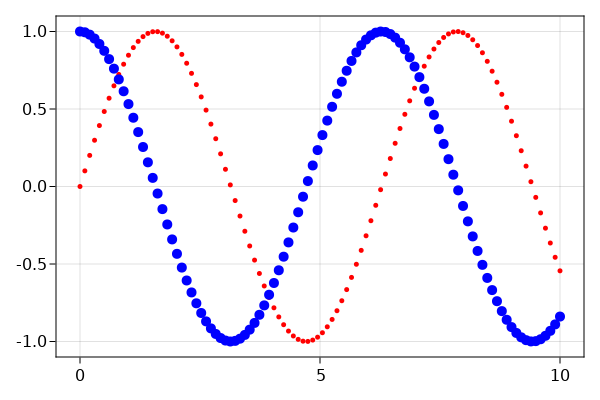

In [4]:
x = range(0, 10, length=100)
y1 = sin.(x)
y2 = cos.(x)

scatter(x, y1, color = :red, markersize = 5, figure=(; resolution=(600, 400)))
scatter!(x, y2, color = :blue, markersize = 10)
current_figure()

In fact, you can specify pretty much anything within the plot creation function:


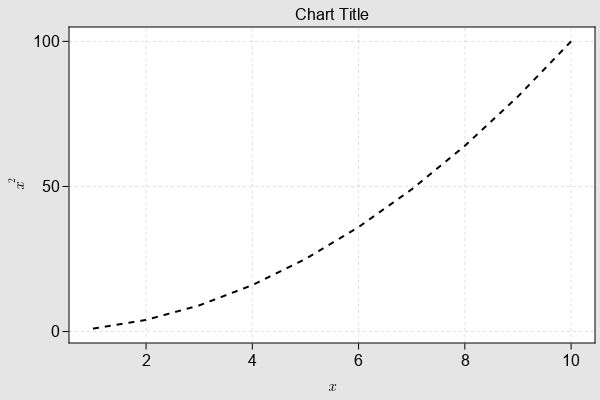

In [5]:
lines(1:10, (1:10).^2; color=:black, linewidth=2, linestyle=:dash,
    figure=(; figure_padding=5, resolution=(600, 400), font="Arial",
        backgroundcolor=:grey90, fontsize=16),
    axis=(; xlabel=L"x", ylabel=L"x^{2}", title="Chart Title",
        xgridstyle=:dash, ygridstyle=:dash))
current_figure()

`Makie` can take a matrix object as well, and there's a `series` plotting function that can do multiple lines at once:


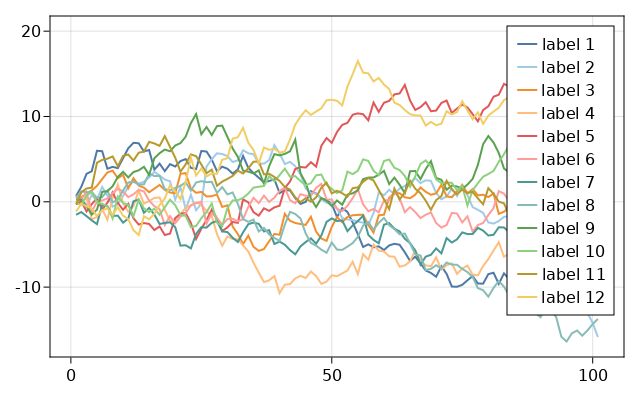

In [35]:
num_lines = 12
dat2 = cumsum(randn(num_lines, 101), dims = 2)
labels=["label $i" for i in 1:num_lines]

# See available_gradients() for a list of available colors you can use
# Makie will error if you don't have enough colors here
fig, ax, sp = series(dat2, labels=labels, color=:tableau_20, figure=(; resolution=(640,400)))
axislegend(ax)
current_figure()

## Aside: Color Maps with `ColorSchemes`

One gripe with Makie: you need to specify each color in your `lines` call, just like in matplotlib. So how do you 'cycle' through a bunch of colors for each of your lines? 

1. `ColorSchemes.colorschemes[:viridis]`: Returns a dictionary of colortypes in the :viridis scheme
2. `cgrad(colors, [values]; )`: Construct a Colorgradient from `colors` and `values`
3. `cmap = cgrad(colorschemes[:virids], 20)`: Creates an array of 20 colors selected from the :viridis color scheme

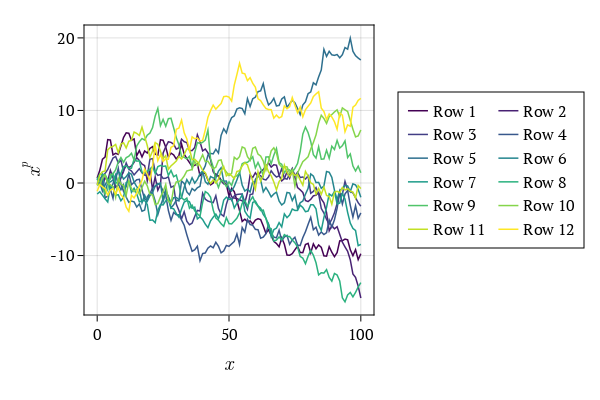

In [73]:
num_lines = 12
cbarPal = :viridis
cmap = cgrad(colorschemes[cbarPal], num_lines, categorical = false)

xs = 0:100

fig = Figure(resolution = (600, 400), font = "CMU Serif")
ax = Axis(fig[1, 1], aspect = 1, xlabel = L"x", ylabel = L"x^{p}", 
          xlabelsize = 20, ylabelsize = 20)
[lines!(xs, dat2[i, :], color=cmap[i], label="Row $i") for i in 1:num_lines]

Legend(fig[1, 2], ax, nbanks = 2)
display(fig)

Julia for Data Science has a great article here on makie colors: https://juliadatascience.io/makie_colors

> Here, we could define a global Theme with a new cycle for colors, however that is not the recommend way to do it. It’s better to define a new theme and use as shown before. Let’s define a new one with a cycle for :color, :linestyle, :marker and a new colormap default. And add these new attributes to our previous publication_theme.

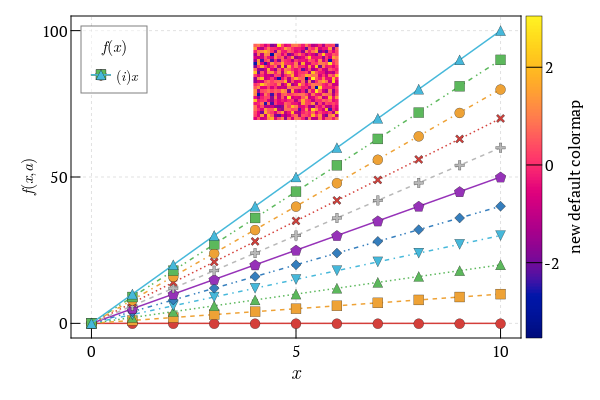

In [75]:
# https://juliadatascience.io/makie_colors

function new_cycle_theme()
    # https://nanx.me/ggsci/reference/pal_locuszoom.html
    my_colors = ["#D43F3AFF", "#EEA236FF", "#5CB85CFF", "#46B8DAFF",
        "#357EBDFF", "#9632B8FF", "#B8B8B8FF"]
    cycle = Cycle([:color, :linestyle, :marker], covary=true) # alltogether
    my_markers = [:circle, :rect, :utriangle, :dtriangle, :diamond,
        :pentagon, :cross, :xcross]
    my_linestyle = [nothing, :dash, :dot, :dashdot, :dashdotdot]
    Theme(
        fontsize=16, font="CMU Serif",
        colormap=:linear_bmy_10_95_c78_n256,
        palette=(color=my_colors, marker=my_markers, linestyle=my_linestyle),
        Lines=(cycle=cycle,), Scatter=(cycle=cycle,),
        Axis=(xlabelsize=20, xgridstyle=:dash, ygridstyle=:dash,
            xtickalign=1, ytickalign=1, yticksize=10, xticksize=10,
            xlabelpadding=-5, xlabel="x", ylabel="y"),
        Legend=(framecolor=(:black, 0.5), bgcolor=(:white, 0.5)),
        Colorbar=(ticksize=16, tickalign=1, spinewidth=0.5),
    )
end

function scatters_and_lines()
    x = collect(0:10)
    xh = LinRange(4, 6, 25)
    yh = LinRange(70, 95, 25)
    h = randn(25, 25)
    fig = Figure(resolution=(600, 400), font="CMU Serif")
    ax = Axis(fig[1, 1], xlabel=L"x", ylabel=L"f(x,a)")
    for i in x
        lines!(ax, x, i .* x; label=L"$(i) x")
        scatter!(ax, x, i .* x; markersize=13, strokewidth=0.25,
            label=L"$(i) x")
    end
    hm = heatmap!(xh, yh, h)
    axislegend(L"f(x)"; merge=true, position=:lt, nbanks=2, labelsize=14)
    Colorbar(fig[1, 2], hm, label="new default colormap")
    limits!(ax, -0.5, 10.5, -5, 105)
    colgap!(fig.layout, 5)
    fig
end

with_theme(scatters_and_lines, new_cycle_theme())

We can see that `Makie` works just fine for vectors and matrices, but what about `DataFrame`s? Well, each column of a dataframe is a vector so you could get by with loops, but we have to write a lot of extra throwaway code which can get annoying fast. 

# AlgebraOfGraphics

While `Makie` is powerful, it does seem a little verbose if you work with tabular data in `DataFrames`. It's recommended if you want to build complex or 'publication quality' plots or you want interactivity, but it could use a wrapper to make things faster for one-off plots. 

`ggplot2` is still the go-to plotting library for R, and using it within the tidyverse feels like a well thought out, integrated system that is both easy to use and easy to layer complexity on top of it. 

`Gadfly` follows very closely in the `ggplot2` Grammar of Graphics style, so it already feels familiar (dare I say pleasing) to use with `DataFramesMeta` and comes with plenty of customization right out of the bat.

What makes the GoG-style plotting libraries feel so powerful is that you can add or remove layers of complexity on top of the plot without having to rewrite a lot of code. It's flexible in that the core building blocks work together seamlessly once you learn the grammar.

Enter `AlgebraOfGraphics`. `AlgebraOfGraphics` uses `Makie` in the background so that you still have all of the options with layouts and attributes, but it allows you to write similarly expressive statements that give you some of the benefits of GoG. However, it's just different enough that it takes some getting used to.

We can start with an example and you can see the code in action:

In [8]:
# on the first run, if it asks for stdin type in 'y' and hit enter to download
penguins = dropmissing(DataFrame(PalmerPenguins.load()))
first(penguins, 6)

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g
,String15,String15,Float64,Float64,Int64,Int64
1,Adelie,Torgersen,39.1,18.7,181,3750
2,Adelie,Torgersen,39.5,17.4,186,3800
3,Adelie,Torgersen,40.3,18.0,195,3250
4,Adelie,Torgersen,36.7,19.3,193,3450
5,Adelie,Torgersen,39.3,20.6,190,3650
6,Adelie,Torgersen,38.9,17.8,181,3625


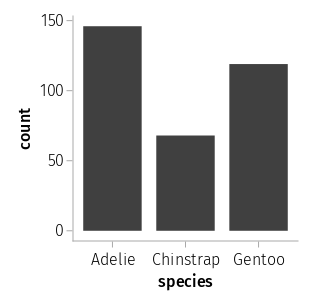

In [9]:
set_aog_theme!() # just like seaborn's sns.set()

axis = (width = 225, height = 225)
penguin_frequency = data(penguins) * frequency() * mapping(:species)

draw(penguin_frequency; axis)

The line:

```julia
penguin_frequency = data(penguins) * frequency() * mapping(:species) 
```

is an example of the *Algebra of Layers*, where Layers are the key building block or abstraction. Each layer is a product of a combination of elementary objects:

* Data
* Mapping: associate data to plot attributes
* Visual: plotting functions from Makie
* Analyses: i.e. Histogram, frequency table

And finally, once you've specified the Layers you use the `draw` function to render it:

```julia
draw(penguin_frequency) # renders the Layers
```

Let's revisit our first `lines` plot from `Makie` using this AoG language:

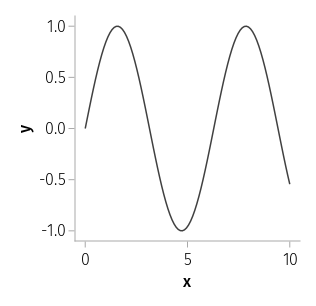

In [10]:
df = DataFrame(x = range(0, 10, length=100), y = sin.(x))
plt = data(df) * mapping(:x, :y) 
draw(plt * visual(Lines); axis)

The multiplication operator (\*) is being used to add objects within the same layer, while the addition operator (+) is used to combine more than one `Layer` into a list of `Layers`. 

The `draw` function operates on either `Layer` or `Layers` and assigns it to the specified figure or axis

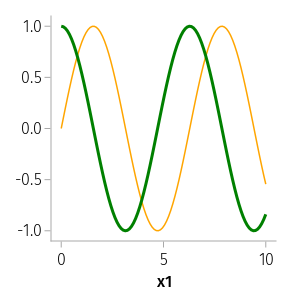

In [23]:
df = DataFrame(dat, :auto)
x2 = data(df) * mapping(:x1, :x2) * visual(Lines, color="orange")
x3 = data(df) * mapping(:x1, :x3) * visual(Lines, color="green", linewidth=3)
# Use the addition operator to combine our two Layer(s)
draw(x2 + x3; axis)

It's still a little early for `AlgebraOfGraphics` but it's nice to see the GoG style on top of the power of `Makie`. I'd still prefer to use `Makie` itself or `Gadfly` for one-off plots - and knowing a lower level library is always useful.